In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import nltk
import os

In [241]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
pd.set_option('precision', 3)
%matplotlib inline

In [5]:
df = pd.read_csv("Vision_Zero_Entry(2).csv", parse_dates=['REQUESTDATE'], dtype={'REQUESTTYPE': 'str', 'COMMENTS': 'str'})
df = df.dropna(subset=['COMMENTS'])
len(df)

6656

In [6]:
df.REQUESTTYPE.value_counts()

of something that is not listed here                                                                         1424
bike facilities don't exist or need improvement                                                               782
people speed                                                                                                  745
people run red lights / stop signs                                                                            663
people don't yield while turning                                                                              461
people double park their vehicles                                                                             430
it’s hard to see / low visibility                                                                             390
sidewalks/ramps don't exist or need improvement                                                               301
people don't yield while going straight                                                 

In [7]:
df['REQUESTTYPE'] = df.REQUESTTYPE.str.replace(".*</span>&nbsp;","")
df.REQUESTTYPE.value_counts()

of something that is not listed here                     1427
bike facilities don't exist or need improvement           782
people speed                                              746
people run red lights / stop signs                        663
people don't yield while turning                          461
people double park their vehicles                         430
it’s hard to see / low visibility                         392
sidewalks/ramps don't exist or need improvement           303
people don't yield while going straight                   264
people cross away from the crosswalks                     255
the roadway surface needs improvement                     222
the wait for the "Walk" signal is too long                209
there are no bike facilities or they need maintenance     128
there's not enough time to cross the street               122
it's too far / too many lanes to cross                     84
there are no sidewalks or they need maintenance            40
the road

In [8]:
df.REQUESTTYPE.replace("there are no bike facilities or they need maintenance",
                       "bike facilities don't exist or need improvement", inplace=True)
df.REQUESTTYPE.replace('people have to wait too long for the "Walk" signal',
                       'the wait for the "Walk" signal is too long', inplace=True)
df.REQUESTTYPE.replace("sidewalks/ramps don't exist or need improvement",
                       "there are no sidewalks or they need maintenance", inplace=True)
df.REQUESTTYPE.replace("the roadway surface needs maintenance",
                       "the roadway surface needs improvement", inplace=True)
df.REQUESTTYPE.replace("people have to cross too many lanes / too far",
                       "it's too far / too many lanes to cross", inplace=True)
df.REQUESTTYPE.replace("people are not given enough time to cross the street",
                       "there's not enough time to cross the street", inplace=True)
df.REQUESTTYPE.replace("it’s hard for people to see each other",
                       "it’s hard to see / low visibility", inplace=True)

In [9]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1427
bike facilities don't exist or need improvement     910
people speed                                        746
people run red lights / stop signs                  663
people don't yield while turning                    461
people double park their vehicles                   430
it’s hard to see / low visibility                   420
there are no sidewalks or they need maintenance     343
people don't yield while going straight             264
the roadway surface needs improvement               256
people cross away from the crosswalks               255
the wait for the "Walk" signal is too long          239
there's not enough time to cross the street         131
it's too far / too many lanes to cross              111
Name: REQUESTTYPE, dtype: int64

In [10]:
len(df.REQUESTTYPE.value_counts())

14

In [11]:
# drop all but relevant columns
df = df[['REQUESTTYPE', 'COMMENTS']]
# Drop simple duplicates
df = df.drop_duplicates()

In [12]:
# Drop some noise from the comments
df.COMMENTS.iloc[np.argsort(df.COMMENTS.str.len())].head(20)

202                 G
7947             test
1156             Test
5920             Test
407              Test
2342          i agree
6558         Non stop
6572         Constant
1778         Too fast
4248      CONSTANTLY.
1124     Liquor store
7125     No bike lane
2531     no sidewalks
1634     No sidewalks
3616    Huge potholes
1145    no bike racks
2636    no bike lanes
7575    Cars speeding
1286    No bike lanes
524     Poor lightung
Name: COMMENTS, dtype: object

In [13]:
df = df[df.COMMENTS.str.len() >= 5]

In [14]:
df.COMMENTS.duplicated().sum()

9

People used the same text with different labels!

In [15]:
df[df.COMMENTS.duplicated(keep=False)]

,REQUESTTYPE,COMMENTS
331,there are no sidewalks or they need maintenance,People park too close to the intersection and ...
333,it’s hard to see / low visibility,People park too close to the intersection and ...
4756,people don't yield while going straight,Drivers regularly barrel through this crosswal...
4757,people don't yield while turning,Drivers regularly barrel through this crosswal...
6278,people speed,There is no cross walk to connect the neighbor...
6279,people cross away from the crosswalks,There is no cross walk to connect the neighbor...
6944,people double park their vehicles,I commute by bike daily on Mass Ave from symph...
6945,bike facilities don't exist or need improvement,I commute by bike daily on Mass Ave from symph...
7098,it’s hard to see / low visibility,There's parking on both sides of this two-way ...
7099,of something that is not listed here,There's parking on both sides of this two-way ...


In [16]:
requesttype = df["REQUESTTYPE"]
comments = df["COMMENTS"]

In [17]:
text_train, text_test, y_train, y_test = train_test_split(comments, requesttype, stratify=requesttype, random_state=0)

# Baseline Model

In [34]:
vect = CountVectorizer()
X_train = vect.fit_transform(text_train)
lr = LogisticRegression(C=.1).fit(X_train, y_train)

In [35]:
X_test = vect.transform(text_test)

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
pred = lr.predict(X_test)

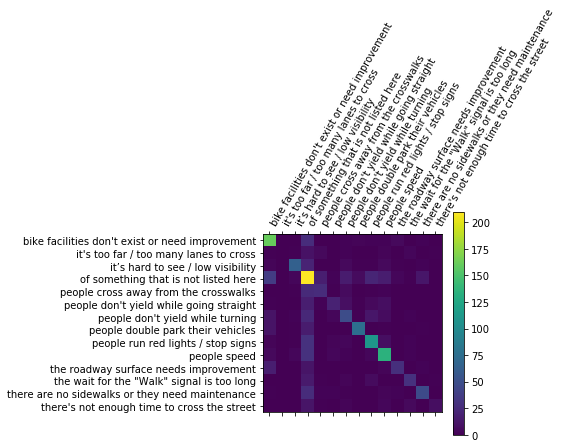

In [38]:
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

In [39]:
lr.score(X_test, y_test)

0.59814241486068109

In [40]:
from sklearn.metrics import f1_score
pred_test = lr.predict(X_test)
f1_score(y_test, pred_test, average="macro")

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.53705327135658576

error message means we did a bad job at smaller classes!

In [41]:
feature_names = vect.get_feature_names()

In [42]:
lr.coef_.shape

(14, 5811)

In [225]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

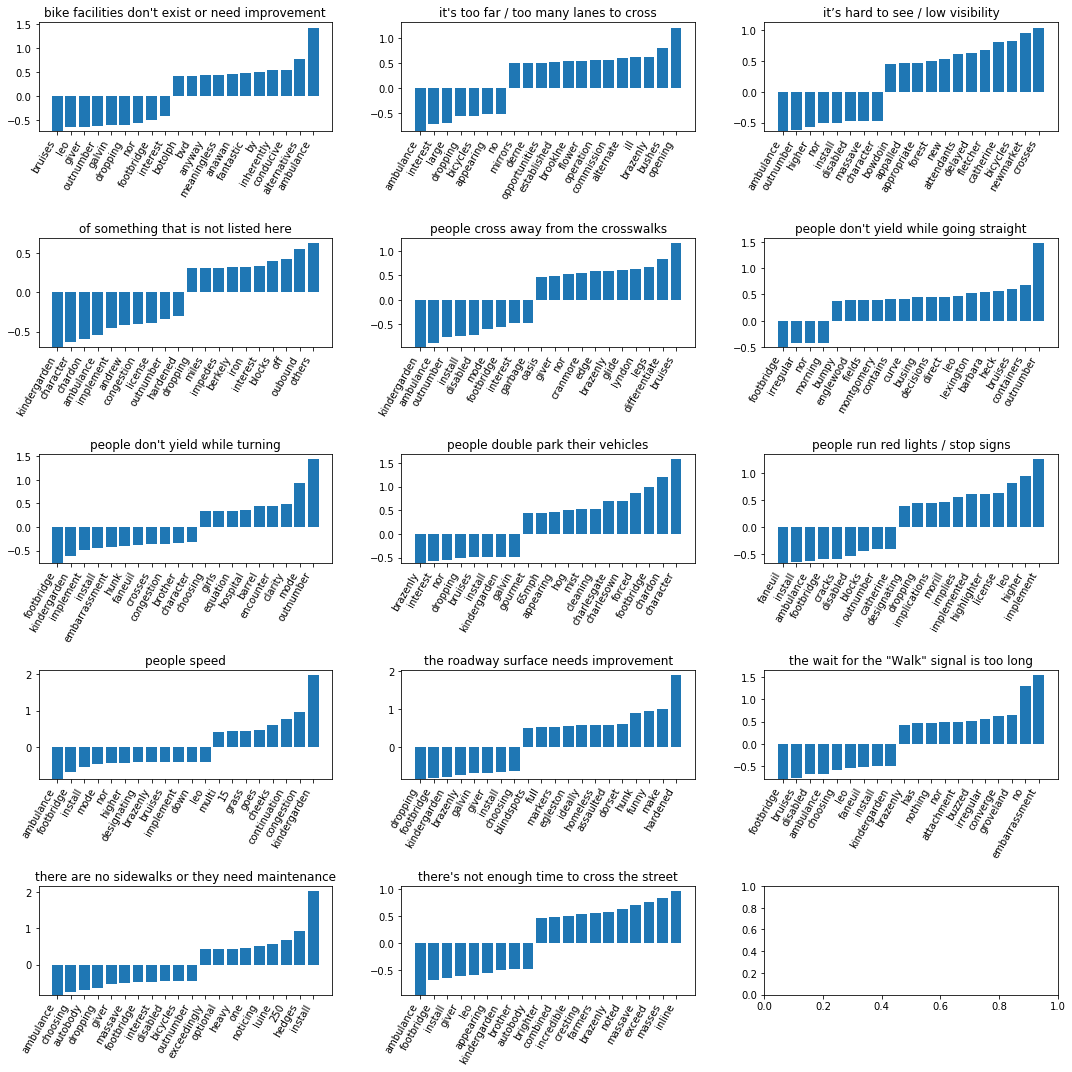

In [226]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

# better dedupe
Let's try some better deduplication.

In [46]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(X_train)

In [47]:
dists.argsort(axis=1)
closest = dists.argsort(axis=1)

In [48]:
# which have close closest neighbors?
near_dupes = np.argsort(dists[np.arange(dists.shape[0]), closest[:, 1]])

In [49]:
for i in range(40):
    print(text_train.iloc[near_dupes[i]])
    print(text_train.iloc[closest[near_dupes[i], 0]])
    print(text_train.iloc[closest[near_dupes[i], 1]])

This is a popular cut through street, where people speed on the straight away and it is not safe for kids. 30MPH is too fast for neighborhood streets, and many are faster than that.
This is a popular cut through street, where people speed on the straight away and it is not safe for kids.  30MPH is too fast for neighborhood streets, and many are faster than that.
This is a popular cut through street, where people speed on the straight away and it is not safe for kids. 30MPH is too fast for neighborhood streets, and many are faster than that.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about the crossing.
There is no cross walk to connect the neighborhood to Allendale Farm. We often walk over there with our toddlers and are very concerned about

Could get duplicate mask of COMMENTS after stripping whitespace and punctuation - better deduplication. But doesn't seem that big an issue.

# More Advanced Model

## grid-search

In [133]:
# This is a giant grid! Probably too big.
param_grid = {'vectorizer': [CountVectorizer(), TfidfVectorizer()],
              'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
              'vectorizer__min_df': [2],
              'clf__C': np.logspace(-3, 2, 6),
              'clf__class_weight': ['balanced', None]
             }

In [134]:
pipe = Pipeline([("vectorizer", None), ("clf", LogisticRegression())])
gs = GridSearchCV(pipe, param_grid, cv=5, scoring="f1_macro", n_jobs=3)

In [135]:
gs.fit(text_train, y_train)

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-s

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', None), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'vectorizer__min_df': [2], 'vectorizer': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocesso...clf__class_weight': ['balanced', None], 'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [136]:
gs.best_params_

{'clf__C': 10.0,
 'clf__class_weight': 'balanced',
 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=2,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 'vectorizer__min_df': 2,
 'vectorizer__ngram_range': (1, 2)}

In [137]:
y_pred = gs.predict(text_test)
f1_score(y_test, pred_test, average="macro")

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.53705327135658576

In [147]:
results = pd.DataFrame(gs.cv_results_)
results['param_vectorizer'] = results.param_vectorizer.astype(str).str.slice(0, 15)
results['param_clf__class_weight'].fillna("none", inplace=True)
res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
                                index=["param_vectorizer__ngram_range", "param_vectorizer", "param_clf__C", "param_clf__class_weight"])

In [148]:
res_pivot

mean_test_score  \
param_vectorizer__ngram_range param_vectorizer param_clf__C param_clf__class_weight                    
(1, 1)                        CountVectorizer  0.001        balanced                        0.429406   
                                                            none                            0.124760   
                                               0.010        balanced                        0.489085   
                                                            none                            0.358444   
                                               0.100        balanced                        0.520639   
                                                            none                            0.501734   
                                               1.000        balanced                        0.512687   
                                                            none                            0.514109   
                                               10.000       balanced                        0.481120   
                                                            none                            0.476602   
                                               100.000      balanced                        0.450545   
                                                            none                            0.448602   
                              TfidfVectorizer  0.001        balanced                        0.025485   
                                                            none                            0.025485   
                                               0.010        balanced                        0.177189   
                                                            none                            0.026888   
                                               0.100        balanced                        0.532815   
                                                            none                            0.179273   
                                               1.000        balanced                        0.544482   
                                                            none                            0.475108   
                                               10.000       balanced                        0.526346   
                                                            none                            0.520041   
                                               100.000      balanced                        0.477779   
                                                            none                            0.477510   
(1, 2)                        CountVectorizer  0.001        balanced                        0.453207   
                                                            none                            0.154903   
                                               0.010        balanced                        0.508632   
                                                            none                            0.388943   
                                               0.100        balanced                        0.539067   
                                                            none                            0.509893   
...                                                                                              ...   
(1, 3)                        TfidfVectorizer  1.000        balanced                        0.549661   
                                                            none                            0.438132   
                                               10.000       balanced                        0.559326   
                                                            none                            0.534820   
                                               100.000      balanced                        0.545074   
                                                            none                            0.533824   
(2, 3)                       

In [151]:
table = res_pivot['mean_test_score'].unstack(["param_clf__class_weight", "param_clf__C"])
table.style.background_gradient(axis=0)

In [157]:
table['balanced'].style.background_gradient(axis=0)

In [ ]:
pd.DataFrame.applymap()

In [286]:
def background_gradient(s, m=None, M=None, cmap='PuBu', low=0, high=0):
    print(s.shape)
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(norm)
    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret

grr = table['balanced']
grr.style.apply(background_gradient, axis=None)

(8, 6)


## Stemming with snowball stemmer (porter2)

In [144]:
from nltk.stem import SnowballStemmer
from nltk import word_tokenize

stemmer = SnowballStemmer("english")

def my_preprocessor(doc):
    doc = doc.replace('[^\w\s]','')
    doc = doc.lower()
    return " ".join([stemmer.stem(word) for word in word_tokenize(doc)])

CountVectorizer(preprocessor=my_preprocessor)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [166]:
from sklearn.externals.joblib import memory
mem = memory.Memory(cachedir="cache", verbose=0)

In [168]:
pipe_stemmer = Pipeline([("vectorizer", TfidfVectorizer(ngram_range=(1, 2), preprocessor=my_preprocessor)),
                         ("clf", LogisticRegression(class_weight="balanced"))], memory=mem)
    
param_grid = {'clf__C': np.logspace(-3, 2, 6)
             }
gs_stemmer = GridSearchCV(pipe_stemmer, param_grid, cv=5, scoring="f1_macro")

In [169]:
gs_stemmer.fit(text_train, y_train)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 3130    Signing is fine. Signal phasing is finally fix...
3791    Major pedestrian and car traffic at this parki...
6319    Those in the rotary have the right of way so s...
7994    Many homeless people are living in and using d...
5338    Drivers do not yield to people in the crosswal...
8319    This is an *awfully* long stretch of main str

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 1134                       very deep, very large potholes
1671    Right turn arrow allows people to speed throug...
5713    Cars and big trucks fly down this street. Ther...
995     There are no crosswalks across Walter Street a...
7806    The bike path by the river is wonderful until ...
1304    The area in front of the park is "no man's la

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 1134                       very deep, very large potholes
1671    Right turn arrow allows people to speed throug...
5713    Cars and big trucks fly down this street. Ther...
995     There are no crosswalks across Walter Street a...
7806    The bike path by the river is wonderful until ...
1304    The area in front of the park is "no man's la

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 1134                       very deep, very large potholes
1671    Right turn arrow allows people to speed throug...
5713    Cars and big trucks fly down this street. Ther...
995     There are no crosswalks across Walter Street a...
7806    The bike path by the river is wonderful until ...
1304    The area in front of the park is "no man's la

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 1134                       very deep, very large potholes
1671    Right turn arrow allows people to speed throug...
5713    Cars and big trucks fly down this street. Ther...
995     There are no crosswalks across Walter Street a...
7806    The bike path by the river is wonderful until ...
1304    The area in front of the park is "no man's la

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function my_preprocessor at 0x7fee503e0ae8>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None), 
None, 1134                       very deep, very large potholes
1671    Right turn arrow allows people to speed throug...
5713    Cars and big trucks fly down this street. Ther...
995     There are no crosswalks across Walter Street a...
7806    The bike path by the river is wonderful until ...
1304    The area in front of the park is "no man's la

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=Memory(cachedir='cache/joblib'),
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function m...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [172]:
gs_stemmer.best_params_

{'clf__C': 10.0}

In [173]:
gs_stemmer.best_score_

0.56710828907909805

In [174]:
y_pred = gs_stemmer.predict(text_test)
f1_score(y_test, pred_test, average="macro")

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1123: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.53705327135658576

In [189]:
vect = CountVectorizer(ngram_range=(1, 2), min_df=4, stop_words='english', preprocessor=my_preprocessor)
X_train = vect.fit_transform(text_train)

In [190]:
len(vect.get_feature_names())

3628

In [203]:
lr = LogisticRegression(class_weight="balanced", C=0.1).fit(X_train, y_train)

In [204]:
X_test = vect.transform(text_test)

In [205]:
lr.score(X_test, y_test)

0.57708978328173377

In [206]:
f1_score(y_test, lr.predict(X_test), average="macro")

0.53866576590341275

In [207]:
f1_score(y_train, lr.predict(X_train), average="macro")

0.73249018689309309

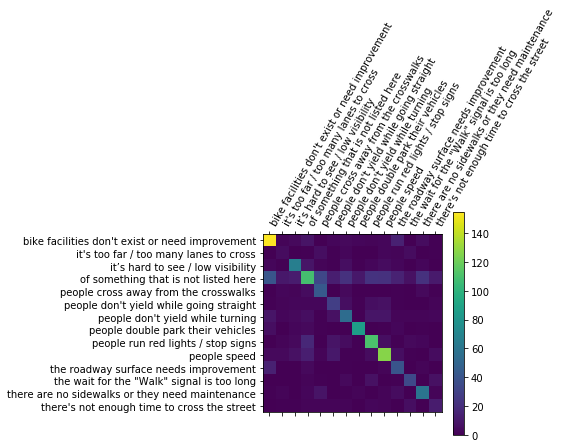

In [208]:
pred = lr.predict(X_test)
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

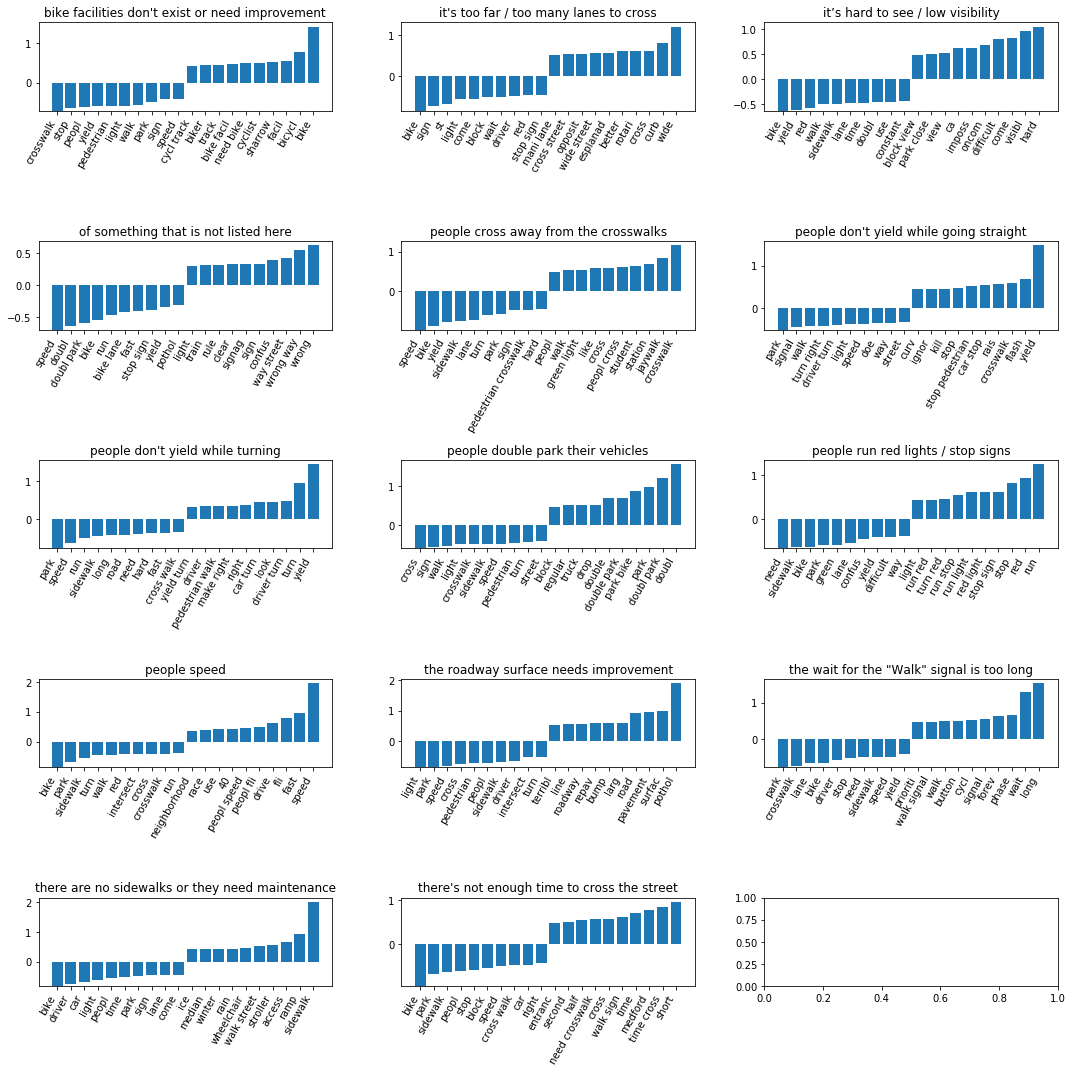

In [209]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

# Clustering and Topic Modelling

In [213]:
from sklearn.decomposition import LatentDirichletAllocation

In [211]:
vect = CountVectorizer(ngram_range=(1, 2), min_df=4, stop_words='english', preprocessor=my_preprocessor)
X_vec = vect.fit_transform(text_train)

In [301]:
lda = LatentDirichletAllocation(n_topics=12, learning_method="batch", random_state=0)
X_lda = lda.fit_transform(X_vec)

In [302]:
lda.score(X_vec)

-589904.13952362491

In [303]:
lda = LatentDirichletAllocation(n_topics=12, learning_method="batch", max_iter=100, random_state=0)
X_lda = lda.fit_transform(X_vec)

In [304]:
lda.score(X_vec)

-584666.11417925369

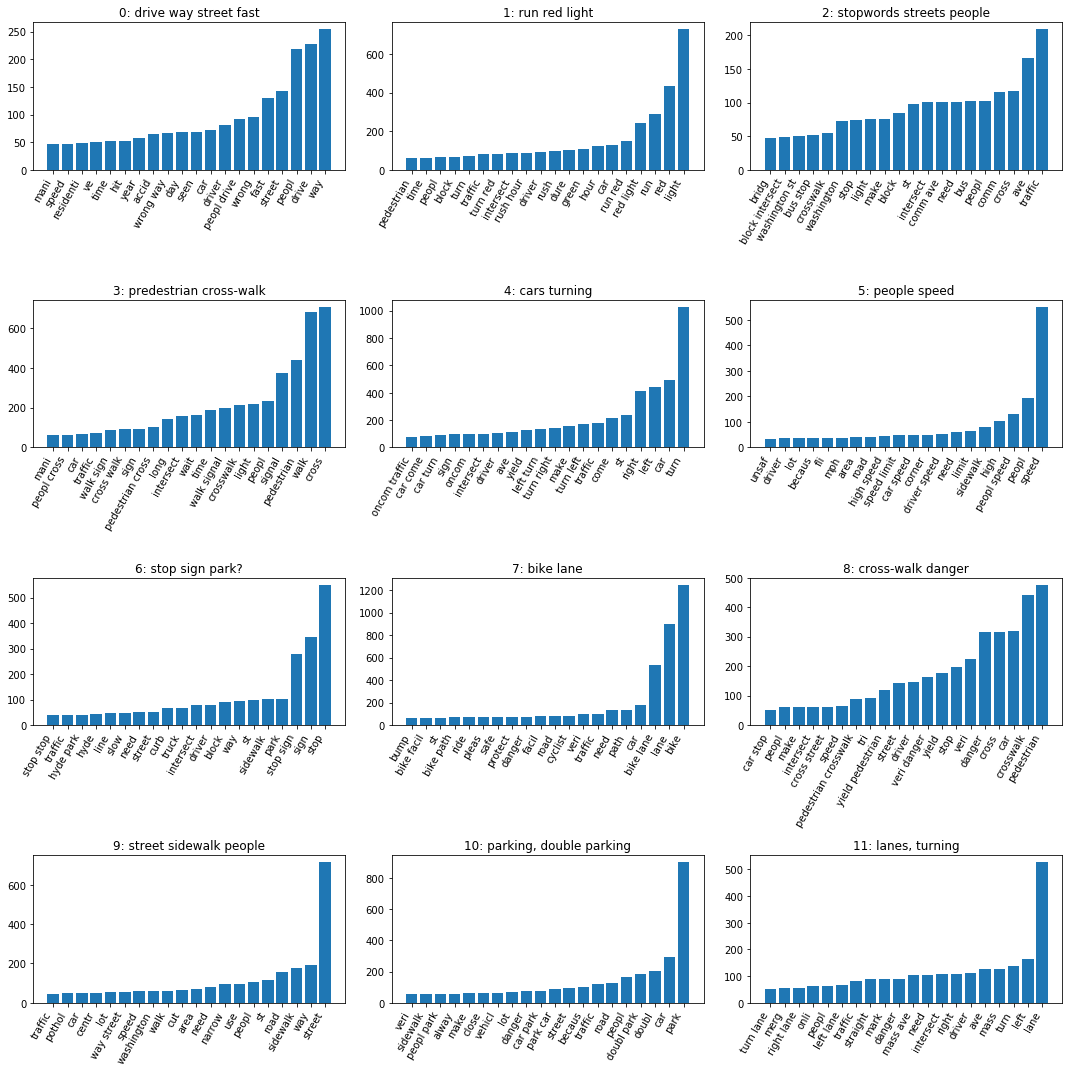

In [305]:
fig, axes = plt.subplots(lda.n_topics // 3, 3, figsize=(15, 15))
labels = ["drive way street fast", "run red light", "stopwords streets people",
          "predestrian cross-walk", "cars turning", "people speed", "stop sign park?", "bike lane",
          "cross-walk danger", "street sidewalk people", "parking, double parking", "lanes, turning"]
for i, (label, ax, coef) in enumerate(zip(labels, axes.ravel(), lda.components_)):
    ax.set_title("{}: {}".format(i, label))
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

In [306]:
classes = lr.classes_
mean_topics = pd.DataFrame(X_lda, columns=labels).groupby(y_train).mean()

In [307]:
mean_topics

,drive way street fast,run red light,stopwords streets people,predestrian cross-walk,cars turning,people speed,stop sign park?,bike lane,cross-walk danger,street sidewalk people,"parking, double parking","lanes, turning"
REQUESTTYPE,,,,,,,,,,,,
bike facilities don't exist or need improvement,0.064,0.061,0.075,0.102,0.095,0.065,0.080,0.125,0.078,0.083,0.109,0.063
it's too far / too many lanes to cross,0.086,0.075,0.081,0.103,0.166,0.075,0.058,0.084,0.045,0.104,0.071,0.053
it’s hard to see / low visibility,0.071,0.071,0.076,0.110,0.097,0.065,0.080,0.134,0.083,0.061,0.091,0.060
of something that is not listed here,0.071,0.073,0.062,0.121,0.103,0.061,0.076,0.123,0.082,0.086,0.085,0.057
people cross away from the crosswalks,0.069,0.057,0.079,0.070,0.113,0.064,0.086,0.129,0.104,0.093,0.089,0.047
people don't yield while going straight,0.058,0.082,0.047,0.087,0.113,0.060,0.072,0.157,0.075,0.101,0.083,0.064
people don't yield while turning,0.055,0.070,0.067,0.129,0.114,0.063,0.083,0.092,0.095,0.070,0.088,0.074
people double park their vehicles,0.070,0.084,0.066,0.118,0.118,0.050,0.084,0.105,0.091,0.082,0.073,0.059
people run red lights / stop signs,0.067,0.079,0.051,0.106,0.122,0.064,0.078,0.134,0.077,0.079,0.090,0.052


In [308]:
mean_topics.style.apply(background_gradient, axis=None)

(14, 12)


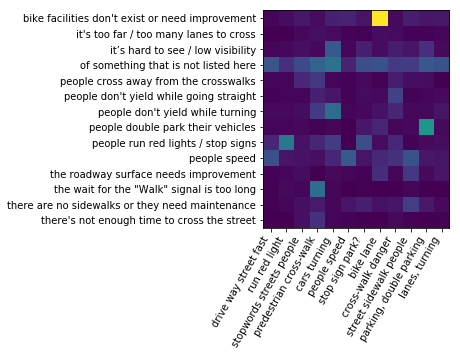

In [309]:
from sklearn.metrics.cluster import contingency_matrix, adjusted_rand_score
lda_max = X_lda.argmax(axis=1)
plt.imshow(contingency_matrix(y_train, lda_max))
plt.xticks(range(12), labels, rotation=60, ha="right")
plt.yticks(range(14), classes);

In [310]:
adjusted_rand_score(y_train, lda_max)

0.10444073599273566

In [291]:
cont_df = pd.DataFrame(contingency_matrix(y_train, lda_max), columns=labels, index=classes)
cont_df.style.background_gradient(axis=1)

In [320]:
sorting.shape

(4845, 12)

In [329]:
sorting = X_lda.argsort(axis=0)[::-1]
labels = ["drive way street fast", "run red light", "stopwords streets people",
          "predestrian cross-walk", "cars turning", "people speed", "stop sign park?", "bike lane",
          "cross-walk danger", "street sidewalk people", "parking, double parking", "lanes, turning"]
feature_names = np.array(vect.get_feature_names())
for i, topic in enumerate(lda.components_):
    print(labels[i])
    print(", ".join(feature_names[np.argsort(topic)[::-1][:5]]))
    for j in range(4):
        print("-")
        print(text_train.iloc[sorting[j, i]])
    print("\n")

drive way street fast
way, drive, peopl, street, fast
-
Car use Forbes as a speed way. Cars drive to fast on Forbes and drive on wrong way on the one way street 
They drive the wrong way on Forbes and Chestnut Ave because the drivers do not want to drive to the end of the street
-
People go the wrong way. It's a 2 way for about 10 feet and then a one way thereafter. People sometimes go the wrong way on a one way. It's really dangerous. 
We should get rid of the 10 feet of two way and make it one way throughout.
-
I've seen a number of cars continue through the "Do Not Enter" signs and go up the last block of Mt Vernon St the wrong way.  Scary.  Is there any way to add reflectors to the Do Not Enter signs?
-
Roanoke is a one-way street.  Frequently, people cut through the neighborhood on it going the wrong way.  they usually speed going the wrong way ao that they can get through there rapidly.


run red light
light, red, run, red light, run red
-
Red light on Beacon is too long so peopl

# More topics

In [311]:
lda42 = LatentDirichletAllocation(n_topics=42, learning_method="batch", max_iter=100, random_state=0)
X_lda42 = lda42.fit_transform(X_vec)

In [312]:
lda_max42 = X_lda42.argmax(axis=1)
adjusted_rand_score(y_train, lda_max42)

0.077998888279422696

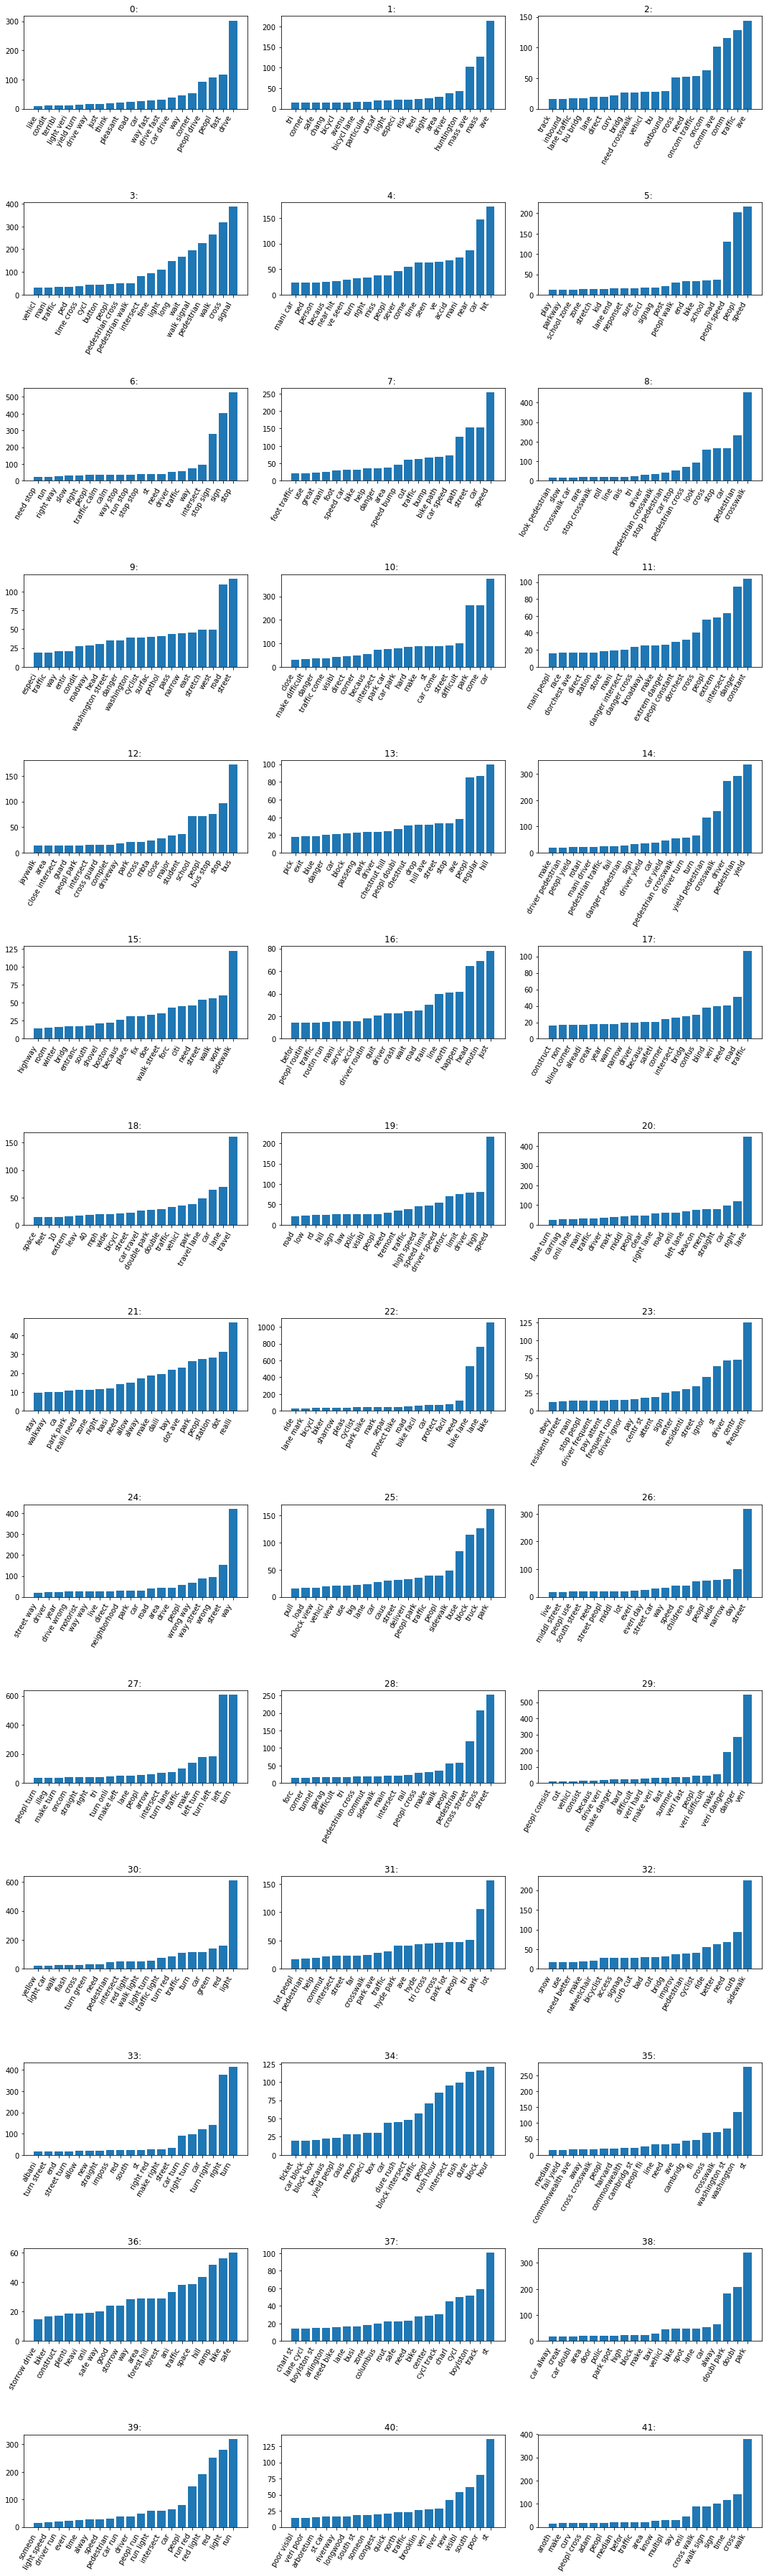

In [314]:
fig, axes = plt.subplots(lda42.n_topics // 3, 3, figsize=(15, 50))
labels = [""] * lda42.n_topics
for i, (label, ax, coef) in enumerate(zip(labels, axes.ravel(), lda42.components_)):
    ax.set_title("{}: {}".format(i, label))
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

bus topic, accident topic, topics for several streets, rush hour, wrong way, parking lot,
people don't stop for pedestrians!

In [333]:
sorting = X_lda42.argsort(axis=0)[::-1]
feature_names = np.array(vect.get_feature_names())
for i, topic in enumerate(lda42.components_):
    print(i)
    print(", ".join(feature_names[np.argsort(topic)[::-1][:5]]))
    for j in range(5):
        print("-")
        print(text_train.iloc[sorting[j, i]])
    print("\n")

0
drive, fast, peopl, peopl drive, corner
-
house at end of bexley has bollards and reflective tape.  I'm wondering if someone has driven into the house before.  people drive too fast down bexley.
-
Cars drive way too fast here
-
People drive fast
-
they drive way too fast.
-
It smells terribly of gas and has for years! There's definitely a leak near this corner.


1
ave, mass, mass ave, huntington, driver
-
Poor to non existent lighting between the Arthur Fiedler Footbridge and the residences at 91 Beacon makes this area dangerous at night.  During summer months transients use this area to congregate and carouse.  Please add lighting and blue call box
-
If a driver intends to go under Mass Ave they speed up after the light at Hereford.
-
In a few Areas  the sidewalk has been taken fenced off by construction.  The sidewalk was not rerouted and the crossing light is behind the fence. Everyone just walks up Harrison Avenue in the street, it's a really bad set up towards whole foods.
-
Th

In [340]:
dontstop = np.argmax(X_lda, axis=1) == 8

In [343]:
pd.DataFrame(contingency_matrix(y_train, dontstop), index=classes)

,0,1
bike facilities don't exist or need improvement,604,9
it's too far / too many lanes to cross,68,11
it’s hard to see / low visibility,278,31
of something that is not listed here,987,65
people cross away from the crosswalks,160,31
people don't yield while going straight,117,75
people don't yield while turning,299,40
people double park their vehicles,310,7
people run red lights / stop signs,446,42
people speed,501,55


In [362]:
from sklearn.preprocessing import maxabs_scale, scale

In [358]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, random_state=0).fit(X_vec)

In [359]:
adjusted_rand_score(y_train, km.labels_)

0.057919679977334444

In [360]:
km = KMeans(n_clusters=10, random_state=0).fit(maxabs_scale(X_vec))
adjusted_rand_score(y_train, km.labels_)

0.057780630262306863

In [367]:
from sklearn.cluster import KMeans
km_lda = KMeans(n_clusters=10, random_state=0).fit(scale(X_lda42))

In [368]:
adjusted_rand_score(y_train, km_lda.labels_)

0.087089247431104022

In [369]:
from sklearn.cluster import KMeans
km_lda20 = KMeans(n_clusters=20, random_state=0).fit(scale(X_lda42))

In [370]:
adjusted_rand_score(y_train, km_lda20.labels_)

0.08247410530311261

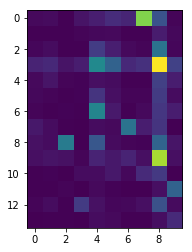

In [372]:
plt.imshow(contingency_matrix(y_train, km_lda.labels_))

# Manual Curation of Classes

In [202]:
len(df[df.COMMENTS.str.contains("wrong way")].COMMENTS.tolist())

76

In [203]:
inds, = np.where(df.COMMENTS.str.contains("wrong way") * df.REQUESTTYPE == "of something that is not listed here")

In [204]:
df = df.copy()

In [205]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'GLOBALID', 'REQUESTID', 'REQUESTTYPE',
       'REQUESTDATE', 'STATUS', 'STREETSEGID', 'COMMENTS', 'USERTYPE'],
      dtype='object')

In [206]:
df.iloc[inds, 5] = "wrong way"

In [214]:
requesttype = df["REQUESTTYPE"]
comments = df["COMMENTS"]
text_train, text_test, y_train, y_test = train_test_split(comments, requesttype, stratify=requesttype, random_state=0)
vect = CountVectorizer(ngram_range=(1, 2), min_df=2, stop_words="english")
X_train = vect.fit_transform(text_train)
X_test = vect.transform(text_test)

In [215]:
requesttype.value_counts()

of something that is not listed here               1353
bike facilities don't exist or need improvement     910
people speed                                        737
people run red lights / stop signs                  660
people don't yield while turning                    461
people double park their vehicles                   426
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     341
people don't yield while going straight             263
the roadway surface needs improvement               255
people cross away from the crosswalks               254
the wait for the "Walk" signal is too long          234
there's not enough time to cross the street         130
it's too far / too many lanes to cross              110
wrong way                                            65
Name: REQUESTTYPE, dtype: int64

In [216]:
lr = LogisticRegression(C=.1).fit(X_train, y_train)

In [217]:
lr.score(X_test, y_test)

0.57955232909860854

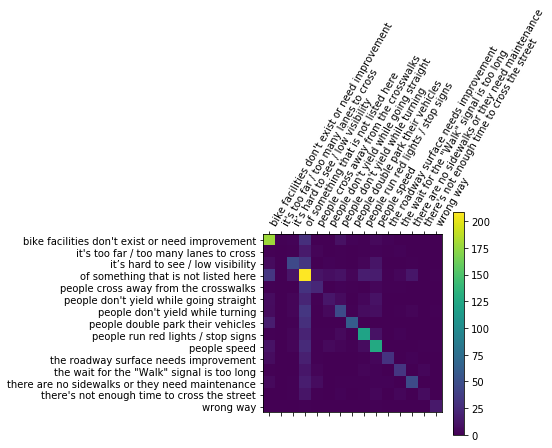

In [218]:
pred = lr.predict(X_test)
plt.matshow(confusion_matrix(y_test, pred))
plt.colorbar()
plt.xticks(range(len(lr.classes_)), lr.classes_, rotation=60, ha='left')
plt.yticks(range(len(lr.classes_)), lr.classes_);

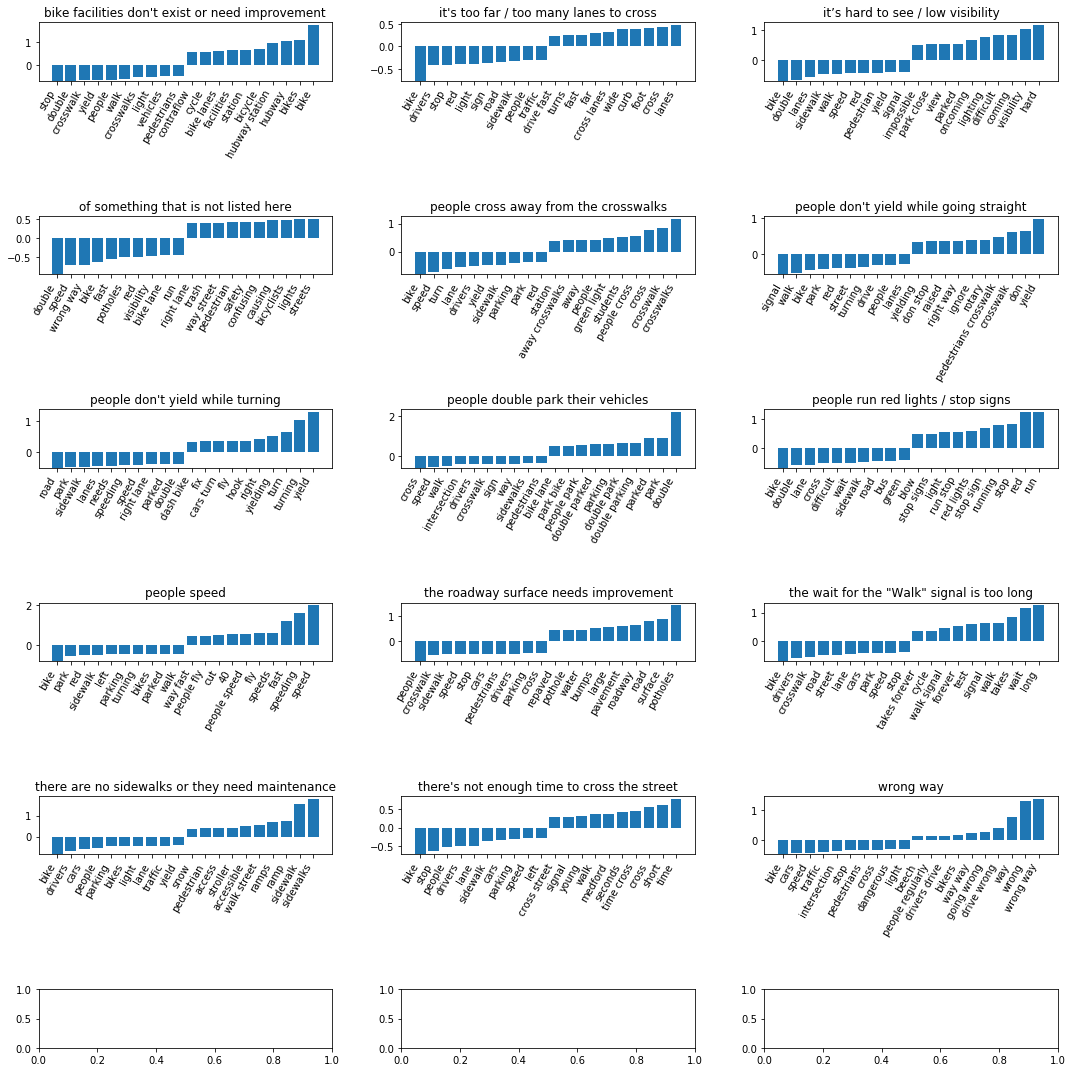

In [219]:
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, np.array(vect.get_feature_names()), ax=ax)
plt.tight_layout()

In [220]:
df[df.COMMENTS.str.contains("trash")].REQUESTTYPE.value_counts()

of something that is not listed here               11
there are no sidewalks or they need maintenance     6
people double park their vehicles                   3
people speed                                        1
wrong way                                           1
the roadway surface needs improvement               1
bike facilities don't exist or need improvement     1
Name: REQUESTTYPE, dtype: int64

In [299]:
"bike lane is in door zone", "bike lane used for driving / turning", "too narrow, should be one-way or restrict parking"

('bike lane is in door zone', 'bike lane used for driving / turning')

In [310]:
df[comments.str.contains("trolley")]

,REQUESTTYPE,COMMENTS
35,it's too far / too many lanes to cross,"An old woman tried to cross a parking lane, 2 ..."
1039,of something that is not listed here,There should be a stopsign so drivers stop for...
1115,of something that is not listed here,This intersection is a clusterfark for drivers...
1216,people don't yield while turning,People are always turning left and coming stra...
1619,it’s hard to see / low visibility,"The driveway for Mission Park is signalized, b..."
3547,of something that is not listed here,The MBTA trolleys consistently run the red lig...
4804,of something that is not listed here,Tour buses/trolleys frequently pull out into t...
5516,of something that is not listed here,There are drivers who do not yield to stopped ...
7152,people cross away from the crosswalks,People jaywalk across Comm Ave after exiting t...


In [312]:
df[comments.str.contains("lights")].REQUESTTYPE.value_counts()

people run red lights / stop signs                 125
of something that is not listed here                91
people speed                                        23
the wait for the "Walk" signal is too long          20
people don't yield while turning                    13
it’s hard to see / low visibility                   13
there's not enough time to cross the street         13
people don't yield while going straight              9
people cross away from the crosswalks                8
people double park their vehicles                    7
bike facilities don't exist or need improvement      6
there are no sidewalks or they need maintenance      4
the roadway surface needs improvement                2
it's too far / too many lanes to cross               1
Name: REQUESTTYPE, dtype: int64

In [314]:
df[comments.str.contains("way street")].REQUESTTYPE.value_counts()

of something that is not listed here               49
people speed                                       18
bike facilities don't exist or need improvement     7
it’s hard to see / low visibility                   7
people double park their vehicles                   5
people don't yield while turning                    2
people don't yield while going straight             2
people run red lights / stop signs                  2
the wait for the "Walk" signal is too long          1
there are no sidewalks or they need maintenance     1
the roadway surface needs improvement               1
Name: REQUESTTYPE, dtype: int64

In [318]:
list(df[comments.str.contains("way street")].COMMENTS)

of something that is not listed here               49
people speed                                       18
bike facilities don't exist or need improvement     7
it’s hard to see / low visibility                   7
people double park their vehicles                   5
people don't yield while turning                    2
people don't yield while going straight             2
people run red lights / stop signs                  2
the wait for the "Walk" signal is too long          1
there are no sidewalks or they need maintenance     1
the roadway surface needs improvement               1
Name: REQUESTTYPE, dtype: int64

In [319]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1402
bike facilities don't exist or need improvement     817
people speed                                        742
people run red lights / stop signs                  650
people don't yield while turning                    452
people double park their vehicles                   423
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     339
people don't yield while going straight             256
people cross away from the crosswalks               254
the roadway surface needs improvement               250
the wait for the "Walk" signal is too long          226
there's not enough time to cross the street         131
it's too far / too many lanes to cross              106
Name: REQUESTTYPE, dtype: int64